In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt

In [26]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 100000
BINS = 25

In [6]:
filenames = {
    "herwig": "../GAN-data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [7]:
def load_data(datatype, stop = None, rotate = True, flip_eta = True):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = pd.DataFrame(dtype = "float32")

    for jet in ["j1", "j2"]:
        output_frame["pt" + jet] = np.sqrt(input_frame["px" + jet]**2 + input_frame["py" + jet]**2)
        output_frame["eta" + jet] = np.arcsinh(input_frame["pz" + jet] / output_frame["pt" + jet])
        output_frame["phi" + jet] = np.arctan2(input_frame["py" + jet], input_frame["px" + jet])
        output_frame["m" + jet] = input_frame["m" + jet]
        output_frame["p" + jet] = np.sqrt(input_frame["pz" + jet]**2 + output_frame["pt" + jet]**2)
        output_frame["e" + jet] = np.sqrt(output_frame["m" + jet]**2 + output_frame["p" + jet]**2)
        output_frame["tau21" + jet] = input_frame["tau2" + jet] / input_frame["tau1" + jet]
        output_frame["tau32" + jet] = input_frame["tau3" + jet] / input_frame["tau2" + jet]
    
    del input_frame
    gc.collect()

    # Not exact rotation, since negative angles for phi2 are flipped across the x-axis. Should be OK due to symmetry.
    if rotate:
        output_frame["phij2"] = np.abs(output_frame["phij2"] - output_frame["phij1"])
        output_frame["phij1"] = 0
    
    if flip_eta:
        flipped_frame = output_frame.copy()
        flipped_frame["etaj1"] *= -1
        flipped_frame["etaj2"] *= -1
        output_frame = output_frame.append(flipped_frame)
        del flipped_frame
        gc.collect()
    
    for jet in ["j1", "j2"]:
        output_frame["px" + jet] = output_frame["pt" + jet] * np.cos(output_frame["phi" + jet])
        output_frame["py" + jet] = output_frame["pt" + jet] * np.sin(output_frame["phi" + jet])
        output_frame["pz" + jet] = output_frame["pt" + jet] * np.sinh(output_frame["eta" + jet])
    
    # Dijet properties
    output_frame["pxjj"] = output_frame["pxj1"] + output_frame["pxj2"]
    output_frame["pyjj"] = output_frame["pyj1"] + output_frame["pyj2"]
    output_frame["pzjj"] = output_frame["pzj1"] + output_frame["pzj2"]
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt(output_frame["pxjj"]**2 + output_frame["pyjj"]**2 + output_frame["pzjj"]**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)

    # NaNs may arise from overly sparse jets with tau1 = 0, tau2 = 0, etc.
    output_frame.dropna(inplace = True)
    output_frame.reset_index(drop = True, inplace = True)
    
    return output_frame.astype('float32')

In [10]:
if TESTING:
    df_bg = load_data("pythiabg", stop = 10000)
    df_sig = load_data("pythiasig", stop = 1000)
else:
    df_bg = load_data("pythiabg")
    df_sig = load_data("pythiasig")

df_bg_SB = df_bg[((df_bg["mjj"] > 2500) & (df_bg["mjj"] < 3300)) | ((df_bg["mjj"] > 3700) & (df_bg["mjj"] < 4500))]
df_bg_SR = df_bg[(df_bg["mjj"] >= 3300) & (df_bg["mjj"] <= 3700)]

df_sig_SB = df_sig[((df_sig["mjj"] > 2500) & (df_sig["mjj"] < 3300)) | ((df_sig["mjj"] > 3700) & (df_sig["mjj"] < 4500))] # This should pretty much be empty
df_sig_SR = df_sig[(df_sig["mjj"] >= 3300) & (df_sig["mjj"] <= 3700)]

df_bg_SB.reset_index(drop = True, inplace = True)
df_bg_SR.reset_index(drop = True, inplace = True)
df_sig_SB.reset_index(drop = True, inplace = True)
df_sig_SR.reset_index(drop = True, inplace = True)

In [11]:
print("df_bg shape {}".format(df_bg.shape))
print("df_sig shape {}".format(df_sig.shape))
print("df_bg_SB shape {}".format(df_bg_SB.shape))
print("df_bg_SR shape {}".format(df_bg_SR.shape))
print("df_sig_SB shape {}".format(df_sig_SB.shape))
print("df_sig_SR shape {}".format(df_sig_SR.shape))
print(df_sig_SR.shape[0]/df_bg_SR.shape[0])
print()

df_bg shape (1999760, 28)
df_sig shape (199930, 28)
df_bg_SB shape (1279456, 28)
df_bg_SR shape (242678, 28)
df_sig_SB shape (47496, 28)
df_sig_SR shape (150596, 28)
0.6205589299400852



In [12]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = cut_data(np.array(df_bg_SB[features]))
np_bg_SR = cut_data(np.array(df_bg_SR[features]))
np_sig_SR = cut_data(np.array(df_sig_SR[features]))
np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
del df_bg_SB
del df_bg_SR
del df_sig_SB
del df_sig_SR
gc.collect()

0

In [13]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [14]:
gen_model = tf.keras.models.load_model('../DijetGan/generator.h5')

In [15]:
def generate_gan(generator, mode = "combined_SR"):
    if mode == "bg_SB":
        realdata = np_bg_SB
        label = "Background Sideband"
        ganlabel = "GAN"
        title = "Background SB Generation (Normalized to Unity)"
    elif mode == "bg_SR":
        realdata = np_bg_SR
        label = "Background Signal Region"
        ganlabel = "GAN Interpolation"
        title = "Background SR Interpolation (Normalized to Unity)"
    elif mode == "sig_SR":
        realdata = np_sig_SR
        label = "BSM Signal"
        ganlabel = "GAN Interpolation"
        title = "BSM Signal Interpolation (Normalized to Unity)"
    elif mode == "combined_SR":
        realdata = np_combined_SR
        label = "Mixed Signal Region"
        ganlabel = "GAN Interpolation"
        title = "Mixed Data SR Interpolation (Normalized to Unity)"
    else:
        raise ValueError("Unexpected mode {} in graph_gan()".format(mode))

    labels = sample_labels(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)
   

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)

    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)

    return fakedata

In [16]:
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)

In [20]:
def sample_labels(refdata = np_bg_SB, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))

In [21]:
def sample_labels_actual(refdata = np_combined_SR,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [22]:
real_data = sample_labels_actual(size= 100000)

In [30]:
tf.random.uniform(SAMPLE_SIZE, NOISE_DIM)

InvalidArgumentError: shape must be a vector of {int32,int64}, got shape [] [Op:RandomUniform]

In [27]:
generated_data = generate_gan(gen_model)

InternalError: cuDNN launch failure : input shape ([100000,8,8,32]) [Op:FusedBatchNormV3]

In [25]:
generated_data.shape

(10000, 10)

In [90]:
classifier_real = real_data[:,[2,6,7,8]]
classifier_fake = generated_data[:,[2,6,7,8]]


In [91]:
classifier_real = np.append(classifier_real,np.ones([len(classifier_real),1]),1)
classifier_fake = np.append(classifier_fake,np.zeros([len(classifier_fake),1]),1)

In [92]:
dataset = np.concatenate((classifier_real,classifier_fake),axis=0)


In [93]:
x_train,x_test,y_train,y_test = train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=1)
x_train,x_val,y_train,y_val= train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=1)

In [94]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(88000, 4)
(88000,)
(22000, 4)
(22000,)
(22000, 4)
(22000,)


In [95]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]

In [96]:
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model


In [97]:
classifier = classifier_model()
history = classifier.fit(x_train, y_train, epochs=50, batch_size=64,validation_data=(x_val,y_val))

 @tf.autograph.experimental.do_not_convert
1375/1375 [==============================] - 12s 9ms/step - loss: 0.4199 - tp: 79493.0000 - fp: 7928.0000 - tn: 95.0000 - fn: 484.0000 - accuracy: 0.9044 - precision: 0.9093 - recall: 0.9939 - auc: 0.5918 - val_loss: 0.3266 - val_tp: 19933.0000 - val_fp: 1942.0000 - val_tn: 35.0000 - val_fn: 90.0000 - val_accuracy: 0.9076 - val_precision: 0.9112 - val_recall: 0.9955 - val_auc: 0.6182
Epoch 2/50
1375/1375 [==============================] - 10s 8ms/step - loss: 0.3107 - tp: 79796.0000 - fp: 7953.0000 - tn: 70.0000 - fn: 181.0000 - accuracy: 0.9076 - precision: 0.9094 - recall: 0.9977 - auc: 0.6127 - val_loss: 0.2975 - val_tp: 20022.0000 - val_fp: 1969.0000 - val_tn: 8.0000 - val_fn: 1.0000 - val_accuracy: 0.9105 - val_precision: 0.9105 - val_recall: 1.0000 - val_auc: 0.6358
Epoch 3/50
1375/1375 [==============================] - 10s 7ms/step - loss: 0.2994 - tp: 79890.0000 - fp: 7984.0000 - tn: 39.0000 - fn: 87.0000 - accuracy: 0.9083 - precisio

In [98]:

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    plt.savefig("Learning_Cu".format(PREFIX, epoch, mode))

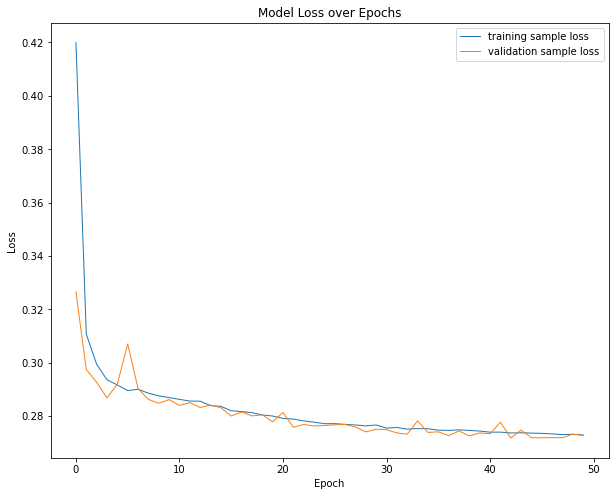

In [99]:
learningCurveLoss(history)

In [100]:
from sklearn.metrics import roc_curve
y_pred = classifier.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [101]:
from sklearn.metrics import auc
print(tpr)
auc_value = auc(fpr, tpr)
print(auc_value)


[0.00000000e+00 4.99425660e-05 6.49253359e-04 ... 9.99950057e-01
 1.00000000e+00 1.00000000e+00]
0.7018869119935444


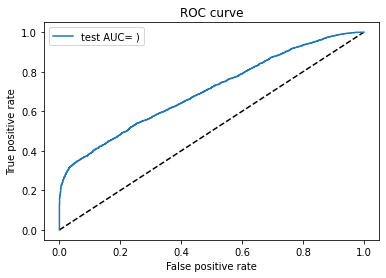

In [103]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='test AUC= )'.format(auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.


In [104]:
sb_ratio = np.logspace(-3,-0.22,6)
mixedsb = []
generated_data = []
for i in sb_ratio:
    sampled_signal = np.random.choice(np_sig_SR.shape[0], (int)(i * np_bg_SR.shape[0]))
    combined = np.concatenate((np_sig_SR[sampled_signal,:],np_bg_SR), axis =0)
    gen =  graph_gan(gen_model)
    generated_data.append(gen)
    mixedsb.append(sample_labels_actual(combined,size= 100000))

NameError: name 'graph_gan' is not defined

In [73]:
print(generated_data[0].shape)
print(mixedsb[0].shape)
print(sb_ratio)

(10000, 10)
(10000, 10)
[0.001      0.0049545  0.02454709 0.1216186  0.60255959]


Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/250 [==============================] - ETA: 0s - loss: 0.8804 - tp: 6718.0000 - fp: 6563.0000 - tn: 6523.0000 - fn: 6180.0000 - accuracy: 0.5096 - precision: 0.5058 - recall: 0.5209 - auc: 0.5096WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001B049E1CD08> and will run it as-is.
Please report t

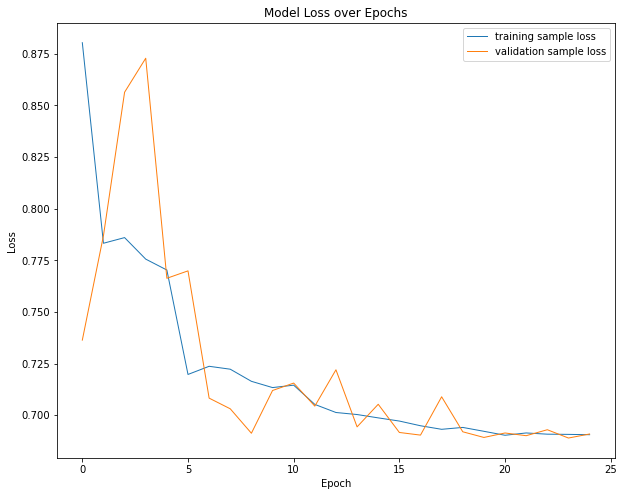

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

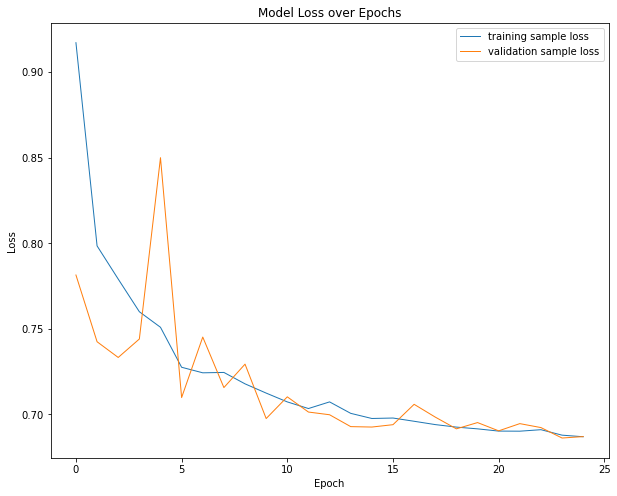

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

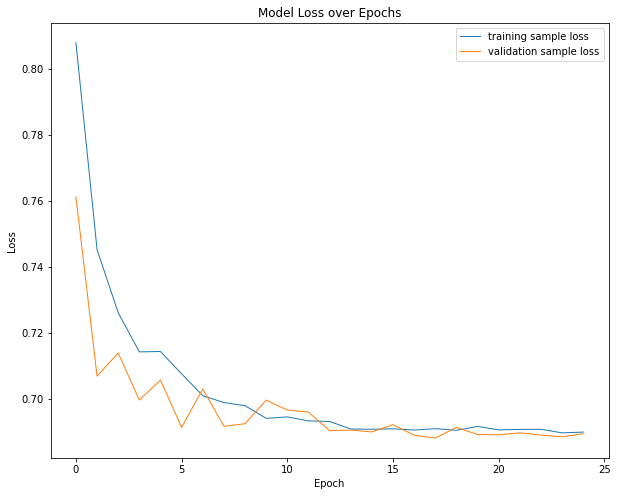

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

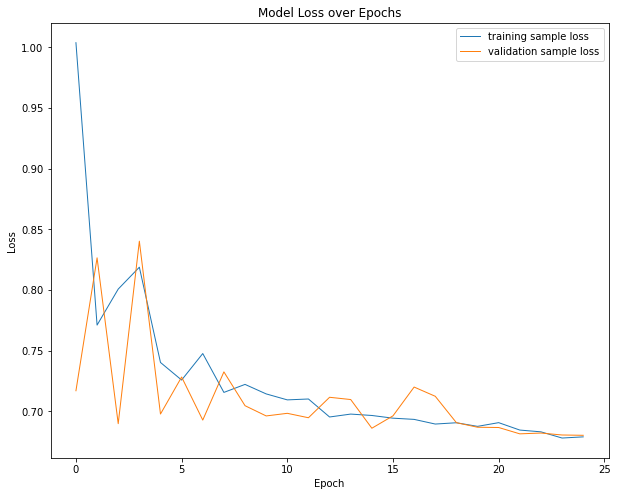

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

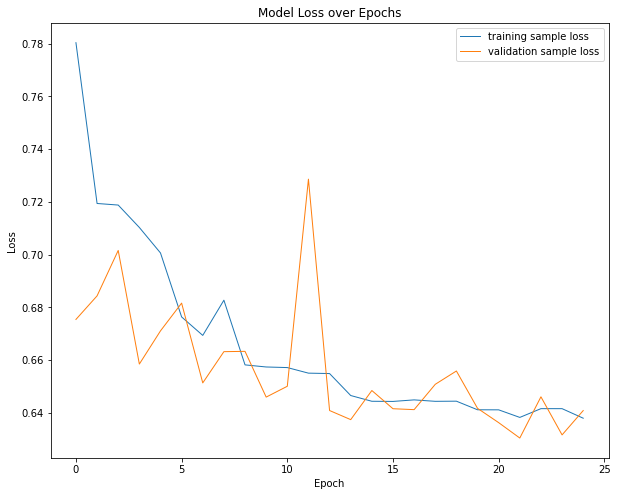

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [74]:
ypred = []
fp, tp,th= [],[],[]
auc_list = []
for i in range(len(mixedsb)):
    classifier_real = mixedsb[i][:,[2,6,7,8]]
    classifier_fake = generated_data[i][:,[2,6,7,8]]
    real = np.append(classifier_real,np.ones([len(classifier_real),1]),1)
    fake = np.append(classifier_fake,np.zeros([len(classifier_fake),1]),1)
    dataset = np.concatenate((real,fake),axis=0)
    x_train,x_test,y_train,y_test = train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=1)
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=1)
    classifier = classifier_model()
    history = classifier.fit(x_train, y_train, epochs=25, batch_size=64,validation_data=(x_val,y_val))
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test).ravel()
    ypred.append(y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list.append(auc_value)
    fp.append(fpr)
    tp.append(tpr)
    th.append(thresholds)

Text(0, 0.5, 'AUC')

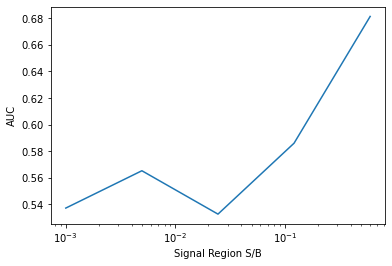

In [107]:
plt.plot(sb_ratio,auc_list)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('AUC')

In [114]:
eff_ratio = []
for i in range(len(tp)):
    tp[i] = tp[i] + 0.0000001
    fp[i] = fp[i] + 0.0000001
    eff_ratio.append(max(tp[i]/np.sqrt(fp[i])) * (sb_ratio[i] * np_bg_SR.shape[0])/(np.sqrt(np_bg_SR.shape[0])))
    


Text(0, 0.5, 'max(TPR/sqrt(FPR)) * S/sqrt(B)')

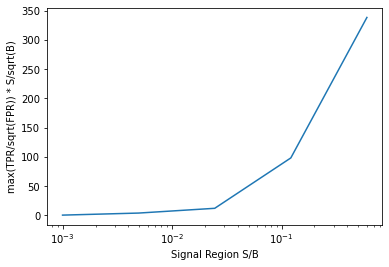

In [115]:
plt.plot(sb_ratio,eff_ratio)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('max(TPR/sqrt(FPR)) * S/sqrt(B)')

In [118]:
th[1]

array([1.5259795 , 0.52597946, 0.5259623 , ..., 0.26285934, 0.25545588,
       0.16909115], dtype=float32)